# References
Visualizing Clusters with Python’s Matplotlib: https://towardsdatascience.com/visualizing-clusters-with-pythons-matplolib-35ae03d87489
* Add convex hull interpolation on scatter plots


# Import libraries

In [162]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim

import matplotlib.pyplot as plt

from elbow_plot_toolkit import determine_max_num_try_cluster, make_elbow_plot
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull
from scipy import interpolate

import plotly.express as px

import folium
import folium.plugins as plugins

# Custom functions

In [163]:
def place_name_to_address(place_name, city_str=None): #Return a location's
    # address by its name
    geolocator = Nominatim(user_agent='my_app') # Initialize Nominatim object with user_agent

    if city_str != None:
        location = geolocator.geocode(place_name+', '+city_str)
    else:
        location = geolocator.geocode(place_name)

    if location:
        return location.address # Extract the address from location object
    else:
        return 'Not found' # Return None if location not found

def coordinates_to_address(latitude, longitude):
    geolocator = Nominatim(user_agent="my_app") # Initialize Nominatim object with user_agent
    location = geolocator.reverse((latitude, longitude)) # Use reverse() method to get location object
    if location:
        return location.address
    else:
        return 'Not found' # Return None if location not found

def coordinates_to_place_name(latitude, longitude):
    geolocator = Nominatim(user_agent="my_app") # Initialize Nominatim object with user_agent
    location = geolocator.reverse((latitude, longitude)) # Use reverse() method to get location object
    if location:
        return location.address.split(",")[0] # Extract the location name from the address string
    else:
        return 'Not found' # Return None if location not found


def address_to_coordinates(address):
    geolocator = Nominatim(user_agent="my_app") # Initialize Nominatim object with user_agent

    location = geolocator.geocode(address) # Use geocode() method to get location object

    if location:
        return location.latitude, location.longitude # Extract the latitude and longitude from location object
    else:
        return None # Return None if location not found

# Read in data

In [164]:
df = pd.read_csv('ChapelHill.csv')
df

,PlaceName,Category
0,North Carolina botanical garden,Garden
1,Ackland art museum,Museum
2,Morehead Planetarium,Museum
3,UNC at chapel hill,Site
4,Morehead-Patterson Bell Tower,Site
5,Coker arboretum,Garden
6,Chapel hill public library,Site
7,Chapel of the cross,Site
8,Forest Theatre,Site
9,Battle Park,Garden


# Convert place_name to address

In [165]:
#The method below was commented out because it runs very slowly
# df["Address"] = df.apply(
#     lambda x: place_name_to_address(
#         place_name=x["PlaceName"],
#         city_str='Chapel Hill'
#     ),
#     axis=1
# )

address_list = []
for placename in df['PlaceName']:
    address_list.append(
        place_name_to_address(
            place_name=placename,
            city_str='Chapel Hill'
        )
    )
df['Address']=address_list

df

,PlaceName,Category,Address
0,North Carolina botanical garden,Garden,"North Carolina Botanical Garden, Fordham Boule..."
1,Ackland art museum,Museum,"Ackland Art Museum, 101, South Columbia Street..."
2,Morehead Planetarium,Museum,"Morehead Planetarium, 250, East Franklin Stree..."
3,UNC at chapel hill,Site,"University of North Carolina, NCNB Aly, Frankl..."
4,Morehead-Patterson Bell Tower,Site,"Morehead-Patterson Bell Tower, 200, South Road..."
5,Coker arboretum,Garden,"Coker Arboretum, 110, Raleigh Street, Franklin..."
6,Chapel hill public library,Site,"Chapel Hill Public Library, 100, Library Drive..."
7,Chapel of the cross,Site,"Chapel of the Cross, 304, East Franklin Street..."
8,Forest Theatre,Site,"Forest Theatre, 300, South Boundary Street, Fr..."
9,Battle Park,Garden,"Battle Park, Baby Hollow, Chapel Hill, Orange ..."


## Fix on not found plane_name
* Some place_name has no address only because the name is a bit wrong. Those
 can be fixed
 * Some places don't have a suitable place_name at all and thus cannot be
 fixed and the altitude can only be provided manually

In [166]:
df[df['Address']=='Not found']

,PlaceName,Category,Address
14,Epilogue Books Chocolate Brews,Bookstore,Not found
15,FRANK Gallery,Site,Not found
17,Top of the Hill Restaurant & Brewery,Restaurant,Not found
20,"Mediterranean Deli, Bakery, and Catering",Restaurant,Not found
23,Stoney River Steakhouse and Grill,Restaurant,Not found
28,The Blue Horn Lounge,Restaurant,Not found
30,CholaNad Restaurant & Bar,Restaurant,Not found
32,Bonchon,Restaurant,Not found
33,Tarantini Italian Restaurant,Restaurant,Not found


Method to fix:
1. Open Google map and locate the place by PlaceName whose Address is "Not
found"
2. Enlarge the map to the max for the highest accuracy
3. Right-click (drag a bit) on the place on the map and the 2 numbers in the
menu are the
 coordinates
4. Feed the coordinate into coordinate_to_address() and it'll tell you the
address
    * If  coordinate_to_address() gives a suitable place_name, use that name
     to correct the place in the original .csv
    * If coordinate_to_address() gives no suitable place_name, then manually
     provide record the coordinates


In [167]:
coordinates_to_address(35.90000313147374, -79.0423935854039)

'Carolina Basketball Museum, 450, Skipper Bowles Drive, Downtown, Chapel Hill, Orange County, North Carolina, 27514, United States'

In [168]:
fix_correct_coordinate_dict = {
    'Epilogue Books Chocolate Brews': (35.91358285610324, -79.05538359568585),
    'FRANK Gallery': (35.910572591584994, -79.06758108248158),
    'Top of the Hill Restaurant & Brewery': (35.91294582504525, -79.05536917740552),
    'Mediterranean Deli, Bakery, and Catering': (35.911309760370585, -79.06099069351794),
    'Stoney River Steakhouse and Grill': (35.92817031282622, -79.02871015024913),
    'The Blue Horn Lounge': (35.91367474811742, -79.05486869378159),
    'CholaNad Restaurant & Bar': (35.91150879898124, -79.06047572961023),
    'Bonchon': (35.91449114859053, -79.05265336005759),
    'Tarantini Italian Restaurant': (35.85401568334828, -79.02502612829082)
}

In [169]:
def fill_coordinates(row): #Use the info in the fix_correct_coordinate_dict
    # to fill in the Latitude and Longitude
    if row['Address'] == 'Not found' and row['PlaceName'] in fix_correct_coordinate_dict:
        row['Latitude'], row['Longitude'] = fix_correct_coordinate_dict[row['PlaceName']]
    return row

# Apply the fill_location function to the DataFrame using apply()
df = df.apply(fill_coordinates, axis=1)

# The 2 lines below just move PlaceName column to be the 1st column
place_name = df.pop('PlaceName')
df.insert(0, 'PlaceName', place_name)

df

,PlaceName,Address,Category,Latitude,Longitude
0,North Carolina botanical garden,"North Carolina Botanical Garden, Fordham Boule...",Garden,NaN,NaN
1,Ackland art museum,"Ackland Art Museum, 101, South Columbia Street...",Museum,NaN,NaN
2,Morehead Planetarium,"Morehead Planetarium, 250, East Franklin Stree...",Museum,NaN,NaN
3,UNC at chapel hill,"University of North Carolina, NCNB Aly, Frankl...",Site,NaN,NaN
4,Morehead-Patterson Bell Tower,"Morehead-Patterson Bell Tower, 200, South Road...",Site,NaN,NaN
5,Coker arboretum,"Coker Arboretum, 110, Raleigh Street, Franklin...",Garden,NaN,NaN
6,Chapel hill public library,"Chapel Hill Public Library, 100, Library Drive...",Site,NaN,NaN
7,Chapel of the cross,"Chapel of the Cross, 304, East Franklin Street...",Site,NaN,NaN
8,Forest Theatre,"Forest Theatre, 300, South Boundary Street, Fr...",Site,NaN,NaN
9,Battle Park,"Battle Park, Baby Hollow, Chapel Hill, Orange ...",Garden,NaN,NaN


# Address to coordinates

In [170]:
def get_coordinates(row):
    if row['Address'] != 'Not found': # check if Address is not "Not found"
        location = address_to_coordinates(row['Address'])
        if location:
            row['Latitude'] = location[0] # add latitude value to row
            row['Longitude'] = location[1] # add longitude value to row
    return row

# apply the function to the dataframe using apply method
df = df.apply(get_coordinates, axis=1)
df

,PlaceName,Address,Category,Latitude,Longitude
0,North Carolina botanical garden,"North Carolina Botanical Garden, Fordham Boule...",Garden,35.897334,-79.031106
1,Ackland art museum,"Ackland Art Museum, 101, South Columbia Street...",Museum,35.912568,-79.054890
2,Morehead Planetarium,"Morehead Planetarium, 250, East Franklin Stree...",Museum,35.913916,-79.050422
3,UNC at chapel hill,"University of North Carolina, NCNB Aly, Frankl...",Site,35.905035,-79.047753
4,Morehead-Patterson Bell Tower,"Morehead-Patterson Bell Tower, 200, South Road...",Site,35.908607,-79.049216
5,Coker arboretum,"Coker Arboretum, 110, Raleigh Street, Franklin...",Garden,35.913749,-79.049046
6,Chapel hill public library,"Chapel Hill Public Library, 100, Library Drive...",Site,35.932130,-79.035753
7,Chapel of the cross,"Chapel of the Cross, 304, East Franklin Street...",Site,35.914613,-79.049949
8,Forest Theatre,"Forest Theatre, 300, South Boundary Street, Fr...",Site,35.913393,-79.044875
9,Battle Park,"Battle Park, Baby Hollow, Chapel Hill, Orange ...",Garden,35.913344,-79.043693


# Map out all places

## Clustering preparation

In [171]:
df_no_restaurant = df[df['Category'] != 'Restaurant'].copy() # Create a new
# dataframe without the Restaurant category. This is because I don't visit
# restaurants

X = df_no_restaurant[['Longitude', 'Latitude']].values # Extract the Longitude and Latitude columns from the new dataframe

X

array([[-79.03110564,  35.8973342 ],
       [-79.05488963,  35.9125678 ],
       [-79.05042204,  35.9139158 ],
       [-79.04775327,  35.90503535],
       [-79.0492161 ,  35.90860695],
       [-79.04904597,  35.91374855],
       [-79.03575313,  35.9321298 ],
       [-79.04994946,  35.91461315],
       [-79.04487461,  35.91339325],
       [-79.04369318,  35.91334435],
       [-79.03607142,  35.9119266 ],
       [-79.05123467,  35.9120628 ],
       [-79.05196914,  35.91333555],
       [-79.0553836 ,  35.91358286],
       [-79.06758108,  35.91057259],
       [-79.0535287 ,  35.9243502 ],
       [-79.04214865,  35.89995045],
       [-79.04519657,  35.91783095]])

### Optimal cluster number determination

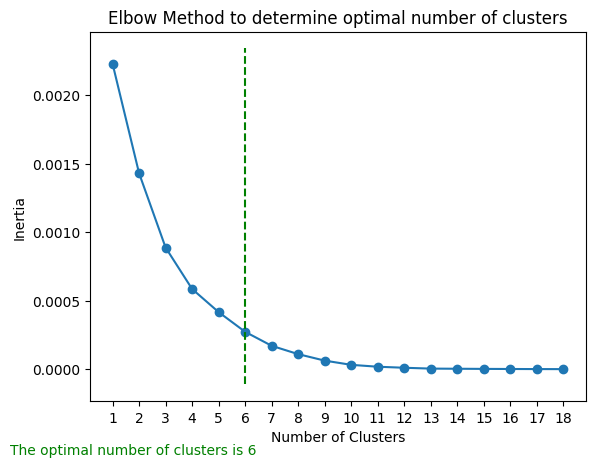

In [172]:
max_num_try_cluster = determine_max_num_try_cluster(X)
optimal_cluster_num = make_elbow_plot(X, max_num_try_cluster)

## Plt scatter map
* Can do clustering on the sites excluding restaurants

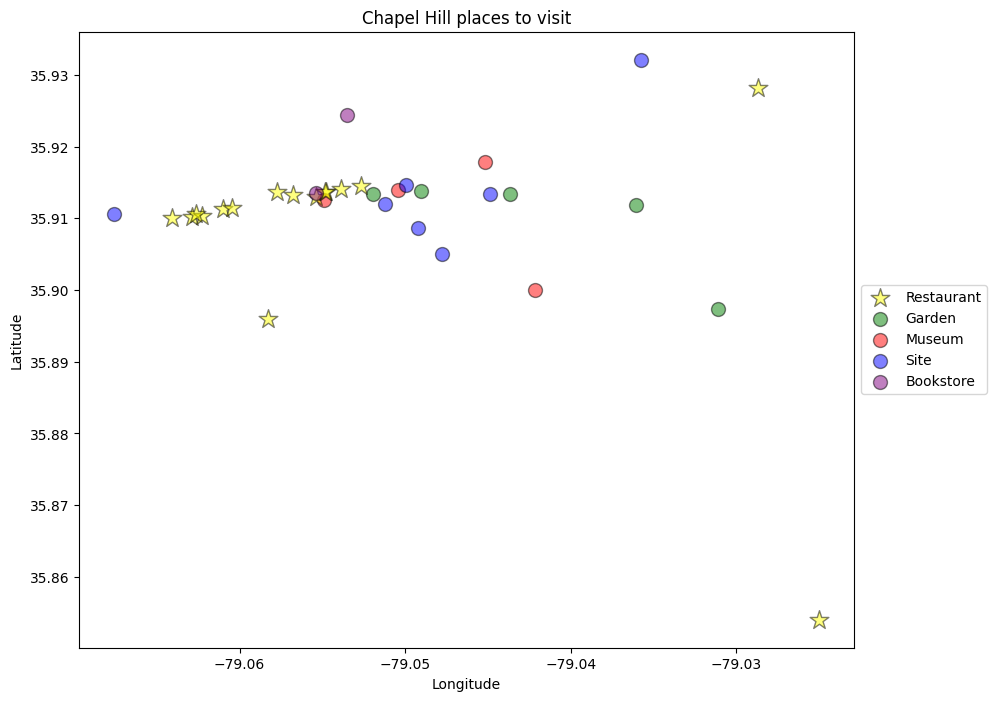

In [173]:
# Define the marker style and color for each category
marker_dict = {
    'Restaurant': '*',
    'Site': 'o',
    'Garden': 'o',
    'Museum': 'o',
    'Bookstore': 'o'
}

color_dict = {
    'Restaurant': 'yellow',
    'Site': 'blue',
    'Garden': 'green',
    'Museum': 'red',
    'Bookstore': 'purple'
}

# Create the scatter plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot each category separately with a different marker style and color
for category in df['Category'].unique():
    mask = df['Category'] == category
    if category == 'Restaurant':
        ax.scatter(df['Longitude'][mask], df['Latitude'][mask],
                   marker=marker_dict[category], color=color_dict[category],
                   s=200, label=category, edgecolor='black', alpha=0.5)
    else:
        ax.scatter(df['Longitude'][mask], df['Latitude'][mask],
                   marker=marker_dict[category], color=color_dict[category],
                   s=100, label=category, edgecolor='black', alpha=0.5)

# Set the chart title and axis labels
ax.set_title('Chapel Hill places to visit')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add a legend to the plot
handles, labels = ax.get_legend_handles_labels()
handles = [handles[i] for i in [3, 0, 1, 2,4]]
labels = [labels[i] for i in [3, 0, 1, 2,4]]
ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1.0, 0.5))

# Show the plot
plt.show()

### KMean clustering

In [174]:
# Perform KMeans clustering on the data points
num_cluster = int(input('How many clusters do you want? The recommendation '
                        'is {}'.format(optimal_cluster_num)) or optimal_cluster_num) #You
# can give a number for clustering or just use the recommended number

kmeans = KMeans(
    n_clusters=num_cluster,
    n_init = 30
)

df_no_restaurant['Cluster'] = kmeans.fit_predict\
    (df_no_restaurant[['Latitude', 'Longitude']]) # Add
# the cluster labels
# as a new
# column to the dataframe

#The 2 lines below move the Cluster column to be the 1st column
cluster = df_no_restaurant.pop('Cluster')
df_no_restaurant.insert(0, 'Cluster', cluster)

df_no_restaurant = df_no_restaurant.sort_values(by=['Cluster']) # Sort the DataFrame by the Cluster column

df_no_restaurant

,Cluster,PlaceName,Address,Category,Latitude,Longitude
16,0,Flyleaf books,"Flyleaf Books, 752, Martin Luther King Junior ...",Bookstore,35.924350,-79.053529
1,1,Ackland art museum,"Ackland Art Museum, 101, South Columbia Street...",Museum,35.912568,-79.054890
2,1,Morehead Planetarium,"Morehead Planetarium, 250, East Franklin Stree...",Museum,35.913916,-79.050422
3,1,UNC at chapel hill,"University of North Carolina, NCNB Aly, Frankl...",Site,35.905035,-79.047753
4,1,Morehead-Patterson Bell Tower,"Morehead-Patterson Bell Tower, 200, South Road...",Site,35.908607,-79.049216
5,1,Coker arboretum,"Coker Arboretum, 110, Raleigh Street, Franklin...",Garden,35.913749,-79.049046
7,1,Chapel of the cross,"Chapel of the Cross, 304, East Franklin Street...",Site,35.914613,-79.049949
11,1,Old Well,"Old Well, 201, East Cameron Avenue, Franklin-R...",Site,35.912063,-79.051235
12,1,McCorkle Place,"McCorkle Place, Franklin-Rosemary Historic Dis...",Garden,35.913336,-79.051969
14,1,Epilogue Books Chocolate Brews,Not found,Bookstore,35.913583,-79.055384


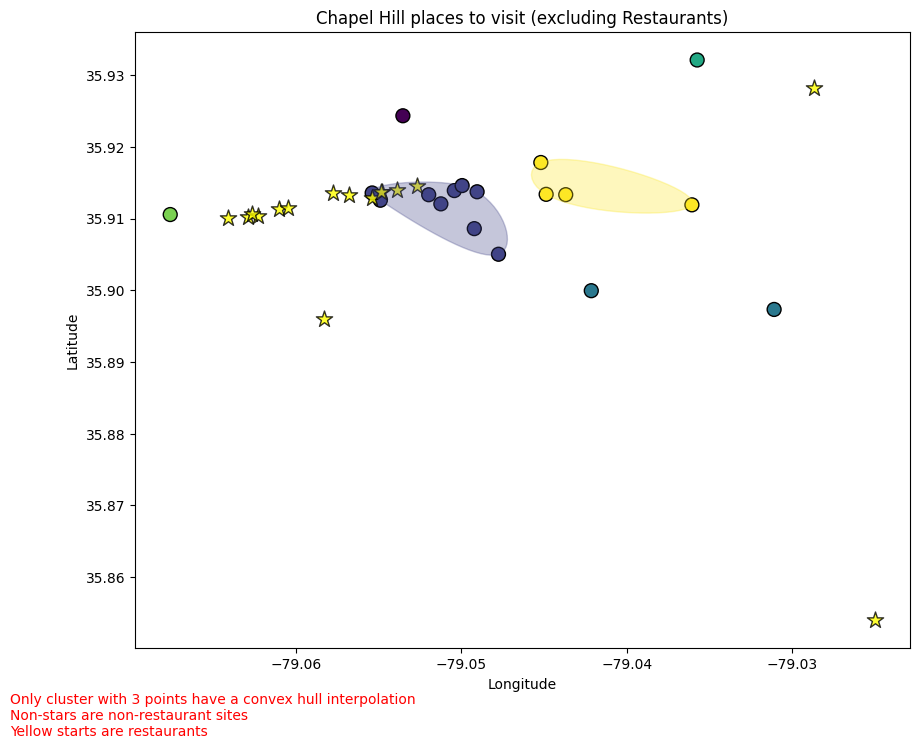

In [175]:
# Plot the clustered data points with the new marker and color dictionaries
fig, ax = plt.subplots(figsize=(10, 8))

scatter_non_restaurant = ax.scatter( #Draw cluster plot for all the
    # non-restaurants
    df_no_restaurant['Longitude'],
    df_no_restaurant['Latitude'],
    c=df_no_restaurant['Cluster'],
    alpha=1,
    s=100,
    edgecolor='black',
)

scatter_restaurant = ax.scatter( #Label out all the restaurants
    df[df['Category']=='Restaurant']['Longitude'],
    df[df['Category']=='Restaurant']['Latitude'],
    marker='*',
    c='yellow',
    alpha=0.8,
    s=150,
    edgecolor='black',
)

# The 2 lines below output the colors used in the scatter plot so the later
# convex hull interpolation can use the same color as the points
labels = df_no_restaurant['Cluster'].unique() # Get the unique cluster labels
color_list = scatter_non_restaurant.cmap(scatter_non_restaurant.norm(labels)) # Get the colors used for each label



for cluster_idx in df_no_restaurant.Cluster.unique(): #Add in the convex
    # hull and interpolate
    if df_no_restaurant[df_no_restaurant.Cluster == cluster_idx].shape[0] >= \
            3: #If a cluster has less than 3 points, plotting the hull will
        # give an error, so you should skip the cluster who has less than 3
        # data points
        points = df_no_restaurant[df_no_restaurant.Cluster ==
                                  cluster_idx][['Longitude','Latitude']].values

        hull = ConvexHull(points) # Get convex hull

        # get x and y coordinates
        # repeat last point to close the polygon
        x_hull = np.append(
            points[hull.vertices,0],
            points[hull.vertices,0][0]
        )
        y_hull = np.append(
            points[hull.vertices,1],
            points[hull.vertices,1][0]
        )

        # Make interpolation
        dist = np.sqrt((x_hull[:-1] - x_hull[1:])**2 + (y_hull[:-1] - y_hull[1:])**2)
        dist_along = np.concatenate(([0], dist.cumsum()))
        spline, u = interpolate.splprep(
            [x_hull, y_hull],
            u=dist_along,
            s=0,
            per=1
        )
        interp_d = np.linspace(dist_along[0], dist_along[-1], 50)
        interp_x, interp_y = interpolate.splev(interp_d, spline)

        # plot shape
        plt.fill(
            interp_x,
            interp_y,
            '--',
            c=color_list[cluster_idx],
            alpha=0.3
        )

ax.set_title('Chapel Hill places to visit (excluding Restaurants)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.figtext(
    0,
    0,
    'Only cluster with 3 points have a convex hull '
    'interpolation\nNon-stars are non-restaurant sites\nYellow '
    'starts are restaurants',
    ha='left',
    fontsize=10,
    color = 'red'
)

plt.show()

## Plotly map
* Interactive maps with place_name in the hover label

In [176]:
# Define the marker style and color for each category
marker_dict = {
    'Restaurant': 'star',

    'Site': 'circle',
    'Garden': 'circle',
    'Museum': 'circle',
    'Bookstore': 'circle'
}

color_dict = {
    'Restaurant': 'yellow',
    'Site': 'blue',
    'Garden': 'green',
    'Museum': 'red',
    'Bookstore': 'purple'
}

# Create the scatter plot using plotly express
fig = px.scatter(
    df,
    x='Longitude',
    y='Latitude',

    color='Category',
    color_discrete_map=color_dict,
    symbol='Category',
    symbol_map=marker_dict,

    hover_name='PlaceName',

    opacity=0.7,
    size_max=10,
    height=600,
    category_orders={'Category': ['Restaurant', 'Site', 'Garden', 'Museum',
                                  'Bookstore']}
)

# Set the chart title and axis labels
fig.update_layout(
    title='Chapel Hill places to visit',
    xaxis_title='Longitude',
    yaxis_title='Latitude',

    #The 2 lines below hide the grids
    xaxis = dict(showgrid=False, zeroline=False),
    yaxis = dict(showgrid=False, zeroline=False),

    plot_bgcolor='white' #Make the plotting background as white

)

# Change the marker style
fig.update_traces(
    marker=dict(
        size=10,
        line=dict(
            width=2,
            color='Black'
        )
    ),
    selector=dict(
        mode='markers'
    ),
    hovertemplate="<b>%{hovertext}</b>"
)

# Show the plot
fig.show()

## Folium map
* Overlap on the real map
* Also generate an interactive HTML map

In [322]:
#Initialize the map
latitude_avg = df['Latitude'].mean()
longitude_avg = df['Longitude'].mean()

map = folium.Map(
    location=[latitude_avg,longitude_avg],
    zoom_start=12,
    control_scale=True,
    tiles = None
)

plugins.Geocoder(
    position='topright'
).add_to(map) #Add in a search bar

#Add in several options for the map
#You can find a list of free tile providers here: http://leaflet-extras.github.io/leaflet-providers/preview/
map_style_list = [
    'OpenStreetMap', #Colorful and has lots of details
    'CartoDB Positron', #Lightly colored with some details
    # 'Stamen Toner', #Very simplified black-and-white map
]
for map_style in map_style_list:
    folium.TileLayer(map_style).add_to(map)
folium.LayerControl(collapsed=False).add_to(map) #Give user the option to
# choose which style to use


#Add in plugins. This section should be put in the same block as the map
# initiation since running these twice will add duplicates
plugins.Fullscreen(
    position='topright',
    title="Expand map",
    title_cancel="Exit expand mode",
    force_separate_button=True
).add_to(map) # Add full screen button
# to map

plugins.MiniMap(toggle_display=True).add_to(map) # Add minimap to map

plugins.Draw(export=True).add_to(map) # Add draw tools to map


map


In [323]:
# Add in all the places
for index, row in df.iterrows():
    latitude = row['Latitude']
    longitude = row['Longitude']
    category = row['Category']
    place_name = row['PlaceName']

    #You have to recreate the icon_style since folium doesn't allow reusing icon_style
    if category == 'Restaurant':
        icon_style = plugins.BeautifyIcon(
            icon='utensils',
            icon_shape='circle',
            border_color='orange', #Use orange here since yellow is too light
            text_color='orange' #This controls the icon image color
        )
    elif category == 'Garden':
        icon_style = plugins.BeautifyIcon(
            icon='leaf',
            icon_shape='circle',
            border_color='green',
            text_color='green' #This controls the icon image color
        )
    elif category == 'Museum':
        icon_style =plugins.BeautifyIcon(
            icon='university',
            icon_shape='circle',
            border_color='red',
            text_color='red' #This controls the icon image color
        )
    elif category == 'Site':
        icon_style = plugins.BeautifyIcon(
            icon='camera',
            border_color='blue',
            text_color='blue'
        )
    elif category == 'Bookstore':
        icon_style  = plugins.BeautifyIcon(
            icon='book',
            icon_shape='circle',
            border_color='purple',
            text_color='purple' #This controls the icon image color
        )
    else:
        print('Run into an unknown category!')

    folium.Marker(
        location=[latitude, longitude],
        popup=place_name,
        icon = icon_style,
        opacity=1
    ).add_to(map)

map

In [321]:
#Save the map as interactive html
map.save('outputs/chapel_hill/chapel_hill.html')

print('HTML map saved')

HTML map saved


In [ ]:

#Add the convex hull to the map
#Folium map will serve as a combination of plt cluster map and the plotly map